# Outward Migration in a Planetesimal Disk
Here we simulate the outward migration of a planet embedded in a planetesimal disk. Like Neptune in the Nice Model, *consistent* outward migration in a planetesimal disk requires a massive inner planet to eject/capture planetesimals shepherded inwards by the migrating outer planet. Otherwise, the planetesimals shepherded inwards can re-interact with the migrating planet and negate (or even reverse!) any outward progress previously made. 

In [1]:
import rebound
import numpy as np
import time as timing
import os

## Setup
First we need to setup the problem with all the various functions we'll need.

In [2]:
#various powerlaws we'll need
def rand_powerlaw(min_v, max_v, slope):
    y = np.random.uniform()
    if slope == -1:
        return np.exp(y*np.log(max_v/min_v) + np.log(min_v))
    else:
        pow_max = pow(max_v, slope+1.)
        pow_min = pow(min_v, slope+1.)
        return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))

def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum

def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

In [3]:
#calculating the semi-major axis
def get_a(sim,planet_index):
    particles = sim.particles
    com = sim.calculate_com()
    p = particles[planet_index]
    mu = sim.G*(com.m+p.m)
    dvx = p.vx - com.vx
    dvy = p.vy - com.vy
    dvz = p.vz - com.vz
    v2 = dvx*dvx + dvy*dvy + dvz*dvz
    dx = p.x - com.x
    dy = p.y - com.y
    dz = p.z - com.z
    r = np.sqrt(dx*dx + dy*dy + dz*dz)
    return -mu/(v2 - 2.*mu/r)

In [4]:
#The outputs for the integrator
def get_outputs(sim,E0,start_t,filename,write_t,write_log,write_lin):
    with open(filename, "a") as writefile:
        dE = abs((sim.calculate_energy() - E0)/E0)
        current_t = timing.time()-start_t
        a = get_a(sim,sim.N_active-1)
        N_mini = 0
        if(sim.integrator == "hybarid"):
            mini = sim.ri_hybarid.mini.contents
            N_mini = mini.N
        too_large = sim.ri_hybarid.timestep_too_large_warning
        writefile.write(','.join(map(str,(sim.t,dE,a,sim.N,N_mini,current_t,too_large))) +"\n")
    write_t = min(write_t*write_log,write_t*write_lin)
    if write_t < sim.t + sim.dt:
        write_t = sim.t + sim.dt
    return write_t

In [5]:
def get_eiasnapshot(sim,filename,eia_counter,eia_snapshot_dt,eia_active):
    if (sim.t > eia_snapshot_dt*eia_counter) & (eia_active == 1):
        #output file
        output = filename.split(".txt")[0]+"_eia%d.txt"%eia_counter
        f = open(output,"a")

        #physics
        particles = sim.particles[1:]
        com = sim.calculate_com()
        for p in particles:
            mu = sim.G*(com.m+p.m)
            dvx = p.vx - com.vx
            dvy = p.vy - com.vy
            dvz = p.vz - com.vz
            v2 = dvx*dvx + dvy*dvy + dvz*dvz
            dx = p.x - com.x
            dy = p.y - com.y
            dz = p.z - com.z
            r = (dx*dx + dy*dy + dz*dz)**(0.5)
            hx = (dy*dvz - dz*dvy)
            hy = (dz*dvx - dx*dvz)
            hz = (dx*dvy - dy*dvx)
            h = (hx*hx + hy*hy + hz*hz)**(0.5)
            vr = (dx*dvx + dy*dvy + dz*dvz)/r
            term1 = v2-mu/r
            term2 = r*vr
            ex = (term1*dx - term2*dvx)/mu
            ey = (term1*dy - term2*dvy)/mu
            ez = (term1*dz - term2*dvz)/mu
            e = (ex*ex + ey*ey + ez*ez)**(0.5)
            a = -mu/(v2 - 2.*mu/r)
            inc = np.arccos(hz/h)
            f.write(','.join(map(str, (sim.t,p.id,p.m,a,e,inc))) +"\n")
        f.close()
        return eia_counter + 1
    else:
        return eia_counter

In [6]:
def get_filename(HSB,dt,run):
    return "output/OutwardMigration_HSB%d_dt%.4f_%d.txt"%(HSB,dt,run)

In [9]:
def problem(HSB, dt, seed, run, eia_active):
    
    #initialization stuff
    filename = get_filename(HSB,dt,run)
    try:
        os.remove(filename)
    except OSError:
        pass
    np.random.seed(seed=seed)
    write_t = dt      #writing to file: ini
    write_log = 1.01  #writing to file: log output
    write_lin = 100   #writing to file: linear output every write_lin years
    
    #initialize the simulation
    sim = rebound.Simulation()
    
    #integrator options
    sim.integrator = "hybarid"
    sim.ri_hybarid.switch_radius = HSB
    sim.ri_hybarid.CE_radius = 20.
    sim.dt = dt
    sim.testparticle_type = 1
    tmax = 1e5*6.283
    #tmax = 100*6.283

    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = "merge"
    sim.boundary = "open"
    boxsize = 80.
    sim.configure_box(boxsize)
    sim.collisions_track_dE = 1
    
    #central star + inner massive body
    sim.add(m=1.,r=0.005) 
    #sim.add(m=5e-4,r=4.67e-4,a=0.6,e=0,inc=0.0001)
    sim.add(m=5e-4,r=4.67e-4,a=3,e=0,inc=0.0001)
    
    #migrating planet
    m_earth = 0.000003003
    m_planet = 2.3*m_earth
    #a_planet = 1
    a_planet = 5
    sim.add(m=m_planet,r=7.88e-5,a=a_planet,e=0,inc=-0.0001)
    
    sim.N_active = sim.N
    
    #planetesimal disk beginning at edge of planet's orbit
    print "Populating planetesimal disk for run %d"%run
    m_pl_tot = m_planet*10.
    N_pl = 20000
    m_pl = m_pl_tot / float(N_pl)
    r_pl = 0.00000934532
    disk_min_a = a_planet
    disk_max_a = a_planet + 3
    while sim.N < (N_pl + sim.N_active):
        a = rand_powerlaw(disk_min_a, disk_max_a,0)
        e = rand_rayleigh(0.005)
        inc = rand_rayleigh(0.005)
        Omega = rand_uniform(0,2*np.pi)
        omega = rand_uniform(0,2*np.pi)
        f = rand_uniform(0,2*np.pi)
        sim.add(m=m_pl, r=r_pl, a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f)
    
    #final physics initialization stuff
    sim.move_to_com()
    E0 = sim.calculate_energy()
    
    #eia_snapshot initialization
    eia_counter = 0
    eia_snapshot_dt = tmax/5.
    if eia_active == 1:
        print "outputting eia_snapshots every %.1f years"%eia_snapshot_dt
    
    print "Begin simulation for run %d"%run
    start_t = timing.time()
    while sim.t < tmax:
        sim.integrate(write_t)
        write_t = get_outputs(sim,E0,start_t,filename,write_t,write_log,write_lin)
        eia_counter = get_eiasnapshot(sim,filename,eia_counter,eia_snapshot_dt,eia_active)
        
    print("Run %d complete in %.2f s with dE=%e."% (run,timing.time()-start_t,abs((sim.calculate_energy() - E0)/E0)))

## Run the problem
Now let's run the problem, making use of the multiprocessing module. 

In [7]:
#Setup parameters
#dt = 0.01
dt = 0.17
HSB = 3
n_runs = 6
output_eia_snapshots = 1 #outputs 5 evenly spaced e,i,a snapshots for all orbiting bodies

ones = np.ones(n_runs)
params = zip(ones*HSB,ones*dt,np.random.randint(0,1000,n_runs),range(n_runs),ones*output_eia_snapshots)

**Warning!** executing the code below might take a long time!

In [18]:
import multiprocessing as mp
def execute(pars):
    problem(pars[0],pars[1],pars[2],pars[3],pars[4])

if __name__== '__main__':
    pool = mp.Pool(processes=len(params))
    pool.map(execute, params)
    pool.close()
    pool.join()

Populating planetesimal disk for run 3
Populating planetesimal disk for run 2
Populating planetesimal disk for run 0
Populating planetesimal disk for run 1
Populating planetesimal disk for run 4
outputting eia_snapshots every 125.7 years
Populating planetesimal disk for run 5
outputting eia_snapshots every 125.7 years
outputting eia_snapshots every 125.7 years
outputting eia_snapshots every 125.7 years
outputting eia_snapshots every 125.7 years
Begin simulation for run 3
Begin simulation for run 2
outputting eia_snapshots every 125.7 years
Begin simulation for run 0
Begin simulation for run 1
Begin simulation for run 4
Begin simulation for run 5
Run 2 complete in 5.48 s with dE=4.323036e-10.
Run 1 complete in 5.48 s with dE=4.334153e-10.
Run 3 complete in 5.55 s with dE=6.605064e-10.
Run 0 complete in 5.55 s with dE=4.259151e-10.
Run 5 complete in 5.51 s with dE=4.094779e-10.
Run 4 complete in 5.56 s with dE=8.502770e-10.


## Plot the results
It's time to plot our results, which were saved in .txt files. 

In [8]:
def get_file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

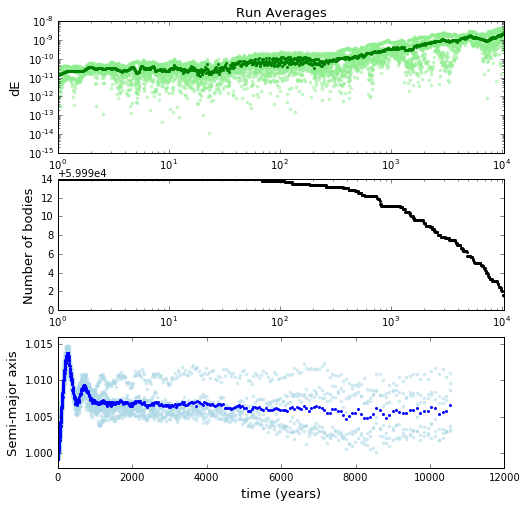

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
%matplotlib inline
filenames = get_filename(HSB,dt,0)
files = glob.glob(filenames.split("0.txt")[0]+"*.txt")

fn = len(files)
i=0
while i < fn:    #just want the main .txt files
    f = files[i]
    string = f.split("_")
    if "eia" in string[-1]:
        files.remove(files[i])
        fn -= 1
    else:
        i += 1

#find array with shortest length (for plotting mid-run purposes)
flen = 1e10
for f in files:
    flen = min(flen,get_file_len(f))

#get data and averages
d = {}
fields=["time","dE","a","N","N_mini","ET","dt_too_large"]
for i,f in enumerate(files):
    d[i] = pd.DataFrame(np.transpose(np.genfromtxt(f, delimiter=",",unpack=True,dtype=float))[0:flen,:],columns=fields)
data = pd.Panel(d)
time = data[0].loc[:,"time"]
Eavg = data.minor_xs("dE").mean(axis=1)
Navg = data.minor_xs("N").mean(axis=1)
aavg = data.minor_xs("a").mean(axis=1)

#setup plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,8))
alpha = 0.5
fontsize=13
maxt = max(time)
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_ylabel('dE',fontsize=fontsize)
axes[0].set_xlim([1,maxt])
axes[1].set_xscale('log')
axes[1].set_ylabel('Number of bodies',fontsize=fontsize)
axes[1].set_xlim([1,maxt])
axes[2].set_ylabel('Semi-major axis',fontsize=fontsize)
axes[2].set_xlabel('time (years)',fontsize=fontsize)
axes[0].set_title("Run Averages",fontsize=fontsize)

#plot
for i in xrange(0,fn):
    axes[0].plot(time,data[i].loc[:,"dE"], '.', alpha=alpha, color='lightgreen')
    axes[2].plot(time,data[i].loc[:,"a"], '.', alpha=alpha, color='lightblue')
axes[0].plot(time, Eavg, '.', markeredgecolor='none', color='green', label='avg.')
axes[1].plot(time, Navg, '.', markeredgecolor='none', color='black', label='avg.')
axes[2].plot(time, aavg, '.', markeredgecolor='none', color='blue', label='avg.')
plt.savefig(filenames.split("0.txt")[0]+"avg.pdf") #save plot

Finally, we can plot an e,i,a snapshot series for a particular run. Need at least two to make a sequence.

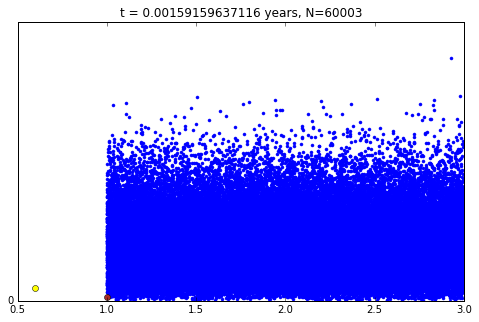

In [18]:
run = 0    #which run do you want to display eia outputs?

eia_name = get_filename(HSB,dt,run)
files = glob.glob(filenames.split(".txt")[0]+"_eia*.txt")
N_eia = len(files)
if N_eia == 1:
    fig, axes = plt.subplots(nrows=N_eia, ncols=1, figsize=(8,5), sharex=True)
    axes.plot(a,e,'.')
    axes.plot(a[0],e[0],'o',color='yellow', label="star")
    axes.plot(a[1],e[1],'o',color='brown', label="planet")
    axes.set_title('t = '+str(time[0]/6.283)+' years, N='+str(len(a)))
    axes.yaxis.set_ticks(np.arange(0,max(e),0.1))
else:
    fig, axes = plt.subplots(nrows=N_eia, ncols=1, figsize=(12,12), sharex=True)
    for i,f in enumerate(files):
        fos = open(f, 'r')
        time, id, m, a, e, inc = np.loadtxt(fos, delimiter=',',unpack=True)
        axes[i].plot(a,e,'.')
        axes[i].plot(a[0],e[0],'o',color='yellow', label="star")
        axes[i].plot(a[1],e[1],'o',color='brown', label="planet")
        axes[i].set_title('t = '+str(time[0]/6.283)+' years, N='+str(len(a)))
        axes[i].yaxis.set_ticks(np.arange(0,max(e),0.1))
    axes[N_eia-1].set_xlabel("semi major axis (AU)",fontsize=10)
    axes[N_eia-1].set_ylabel("eccentricity",fontsize=10)
    axes[N_eia-1].legend(loc="upper left",numpoints=1,fontsize=8)
plt.savefig(filenames.split(".txt")[0]+"_eia.pdf") #save plot